In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
import json
from matplotlib.ticker import MaxNLocator
import numpy as np
from sklearn.linear_model import LinearRegression

In [17]:
# Metric files: Dictionnary
#   - Key: metrics category
#   - Value: array of Tuples:
#       - Elt 0: index of data point in global graphs
#       - Elt 1: path to metric file
#       - Elt 2: legend in detailed graphs, None if not displayed

metric_files = {
    'KW-train': [
        (0, 'data_output/metrics_raw.csv', 'train-raw'),
        (1, 'data_output/metrics_epoch_1_KW.csv', None),
        (3, 'data_output/metrics_epoch_3_KW.csv', None),
        (4, 'data_output/metrics_epoch_4_KW.csv', None),
        (5, 'data_output/metrics_epoch_5_KW.csv', None),
        (6, 'data_output/metrics_epoch_6_KW.csv', None),
        (8, 'data_output/metrics_epoch_8_KW.csv', None),
        (9, 'data_output/metrics_epoch_9_KW.csv', None),
        (10, 'data_output/metrics_epoch_10_KW.csv', None)# 'KW-train-10'),
    ],
    'KW-eval': [
#         (0, 'data_output/metrics_raw.csv', 'train-raw'),
        (1, 'data_output/metrics_epoch_1_KW_eval.csv', None),
        (3, 'data_output/metrics_epoch_3_KW_eval.csv', None),
        (4, 'data_output/metrics_epoch_4_KW_eval.csv', None),
        (5, 'data_output/metrics_epoch_5_KW_eval.csv', None),
        (6, 'data_output/metrics_epoch_6_KW_eval.csv', None),
        (8, 'data_output/metrics_epoch_8_KW_eval.csv', None),
        (9, 'data_output/metrics_epoch_9_KW_eval.csv', None),
        (10, 'data_output/metrics_epoch_10_KW_eval.csv', 'KW-eval-10'),
    ],
    'BART-train': [
        (0, 'data_output/metrics_raw.csv', None),
        (1, 'data_output/metrics_epoch_1_BART.csv', None),
        (3, 'data_output/metrics_epoch_3_BART.csv', None),
        (4, 'data_output/metrics_epoch_4_BART.csv', None),
        (5, 'data_output/metrics_epoch_5_BART.csv', None),
        (6, 'data_output/metrics_epoch_6_BART.csv', None),
        (8, 'data_output/metrics_epoch_8_BART.csv', None),
        (9, 'data_output/metrics_epoch_9_BART.csv', None),
        (10, 'data_output/metrics_epoch_10_BART.csv', None)# 'BART-train-10'),
    ],
    'BART-eval': [
#         (0, 'data_output/metrics_raw.csv', None),
        (1, 'data_output/metrics_epoch_1_BART_eval.csv', None),
        (3, 'data_output/metrics_epoch_3_BART_eval.csv', None),
        (4, 'data_output/metrics_epoch_4_BART_eval.csv', None),
        (5, 'data_output/metrics_epoch_5_BART_eval.csv', None),
        (6, 'data_output/metrics_epoch_6_BART_eval.csv', None),
        (8, 'data_output/metrics_epoch_8_BART_eval.csv', None),
        (9, 'data_output/metrics_epoch_9_BART_eval.csv', None),
        (10, 'data_output/metrics_epoch_10_BART_eval.csv', None)# 'BART-eval-10'),
    ]
}

In [18]:
# Loading data

all_data = {}
means = {}
for k, v in metric_files.items():
    all_data[k] = [pd.read_csv(file) for (index, file, display) in v]
    means[k] = [{'epoch': index} for (index, file, display) in v]


In [19]:
def generation_analysis(generation_file):
    gen_data = json.load(open(generation_file, 'r'))

    # Example of paragraphs
    sample = 300
    print('\nORIGINAL:\n', gen_data[sample]['original']['P2'])
    print('\nGENERATED:\n', gen_data[sample]['generated'])

    # Counting occurences of [P2] token
    print("\n\tGenerated paragraphs with [P2] token inside:",
          len([1 for entry in gen_data if '[P2]' in entry['generated']]),
         '/', len(gen_data))

    # Checking that endoftext tokens are respected
    eot = '<|endoftext|>'
    for entry in gen_data:
        gen = entry['generated']
        index_of_eot = gen.find(eot)
        if index_of_eot > -1:
            while index_of_eot < len(gen):
                assert gen[index_of_eot:].startswith(eot)
                index_of_eot += len(eot)

    print("\n\tValidated that there was no text after <|endoftext|>")

    # Histogram of generated and original paragraphs' lengths
    plt.figure(figsize=(10, 10))
    sns.distplot([len(entry['generated'].replace('<|endoftext|>', '')) for entry in gen_data], bins=[i*100 for i in range(20)], axlabel='Length (chars)', label='Generated')
    sns.distplot([len(entry['original']['P2']) for entry in gen_data], axlabel='Length (chars)', bins=[i*100 for i in range(20)], label='Original')
    plt.legend()
    plt.show()

    # Correlation of generated and original paragraphs' lengths
    plt.figure(figsize=(10, 10))
    data_points = np.array([[len(entry['original']['P2']) for entry in gen_data], [len(entry['generated'].replace('<|endoftext|>', '')) for entry in gen_data]], dtype=int).T
    sns.scatterplot(data_points[:, 0], data_points[:, 1])

    reg = LinearRegression().fit(data_points[:, 0][:, np.newaxis], data_points[:, 1])
    predicted = reg.predict(np.array([i for i in range(2000)])[:, np.newaxis])

    print("\tCorrelation score:", reg.score(data_points[:, 0][:, np.newaxis], data_points[:, 1]))

    sns.lineplot(x=[i for i in range(2000)], y=predicted, color='black')

    plt.xlabel('Original length (chars)')
    plt.ylabel('Generated length (chars)')
    plt.show()

def display_metrics_distributions():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 7.5*3))

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            perplex = [elt for elt in d['perplexity'] if elt < 5]

            if display:
                sns.distplot(d['similarity'], ax=axs[0, 0], axlabel='BERT-similarity', label=lbl)
                sns.distplot(perplex, ax=axs[0, 1], axlabel='GPT2-perplexity', label=lbl)
                sns.distplot([elt for elt in d['rouge_1'] if not pd.isnull(elt)], ax=axs[1, 0], axlabel='rouge_1', label=lbl)
                sns.distplot([elt for elt in d['rouge_2'] if elt < 0.1], ax=axs[1, 1], axlabel='rouge_2', label=lbl)
                sns.distplot([elt for elt in d['rouge_l'] if not pd.isnull(elt)], ax=axs[2, 0], axlabel='rouge_l', label=lbl)
                sns.distplot(d['bleu_score']*1e230, ax=axs[2, 1], axlabel='bleu_score', label=lbl)

            means[category][i]['similarity'] = d['similarity'].mean()
            means[category][i]['perplexity'] = sum(perplex) / len(perplex)
            means[category][i]['rouge-1'] = d['rouge_1'].mean()
            means[category][i]['rouge-2'] = d['rouge_2'].mean()
            means[category][i]['rouge-l'] = d['rouge_l'].mean()
            means[category][i]['bleu-score'] = d['bleu_score'].mean()

    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    plt.show()

def display_detailed_entities_distributions():
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            if display:
                sns.distplot([elt for elt in d['proportion_of_persons'] if elt != -1], bins=10, ax=axs[0, 0], axlabel='persons-proportion', label=lbl)
                sns.distplot([elt for elt in d['proportion_of_locations'] if elt != -1], bins=10, ax=axs[0, 1], axlabel='locations-proportion', label=lbl)
                sns.distplot([elt for elt in d['proportion_of_organisations'] if elt != -1], bins=10, ax=axs[1, 0], axlabel='organisations-proportion', label=lbl)
                sns.distplot([elt for elt in d['proportion_of_misc'] if elt != -1], ax=axs[1, 1], bins=10, axlabel='misc-proportion', label=lbl)

    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    plt.show()
    
def display_entities_distributions():
    fig = plt.subplots(figsize=(7, 7))

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            new_data = []
            for per, loc, org, mis in zip(d['proportion_of_persons'], d['proportion_of_locations'], d['proportion_of_organisations'], d['proportion_of_misc']):
                elts = [elt for elt in [per, loc, org, mis] if elt != -1]
                if len(elts) == 0:
                    continue
                new_data.append(sum(elts) / len(elts))

            if display:
                sns.distplot(new_data, axlabel='entities-proportion', bins=20, label=lbl)
            means[category][i]['entities-proportion'] = sum(new_data) / len(new_data)
    plt.legend()
    plt.show()

def display_keywords_distributions():
    fig = plt.subplots(figsize=(7, 7))
    bins = 20

    for category, dataframes in all_data.items():
        for i, d in enumerate(dataframes):
            lbl = metric_files[category][i][2]
            display = lbl is not None

            elts = [elt for elt in d['keyword_proportion'] if not pd.isnull(elt)]
            if display:
                sns.distplot(elts, bins=[i/bins for i in range(bins)], axlabel='keywords-proportion', label=lbl)
            means[category][i]['keywords-proportion'] = sum(elts) / len(elts)
            
    plt.legend()
    plt.show()

def display_training_graphs():
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 15))

    metrics = ['similarity', 'perplexity', 'rouge-1', 'rouge-2', 'rouge-l', 'bleu-score', 'entities-proportion', 'keywords-proportion']

    for i, metric in enumerate(metrics):
        x = i % 2
        y = i // 2

        for category, cat_means in means.items():
            axs[y, x].plot([m['epoch'] for m in cat_means], [m[metric] for m in cat_means], label=category)

        axs[y, x].set_title('Mean "' + metric + '" evolution')
        axs[y, x].xaxis.set_major_locator(MaxNLocator(integer=True))
        if y == 3:
            axs[y, x].set_xlabel('epochs')
        axs[y, x].set_ylabel('score')
        axs[y, x].legend(loc='lower right')

    plt.show()


ORIGINAL:
 I was extremely put out at this reception, and the last remark, which seemed like a daft wife’s, left me near hand speechless. “I see I have fallen under your displeasure, ma’am,” said I. “Yet I will still be so bold as ask after Mistress Drummond.” She considered me with a burning eye, her lips pressed close together into twenty creases, her hand shaking on her staff. “This cows all!” she cried. “Ye come to me to speir for her? Would God I knew!” “She is not here?” I cried. She threw up her chin and made a step and a cry at me, so that I fell back incontinent. “Out upon your leeing throat!” she cried. “What! ye come and speir at me! She’s in jyle, whaur ye took her to—that’s all there is to it. And of a’ the beings ever I beheld in breeks, to think it should be to you! Ye timmer scoun’rel, if I had a male left to my name I would have your jaicket dustit till ye raired.” I thought it not good to delay longer in that place, because I remarked her passion to be rising. As I t

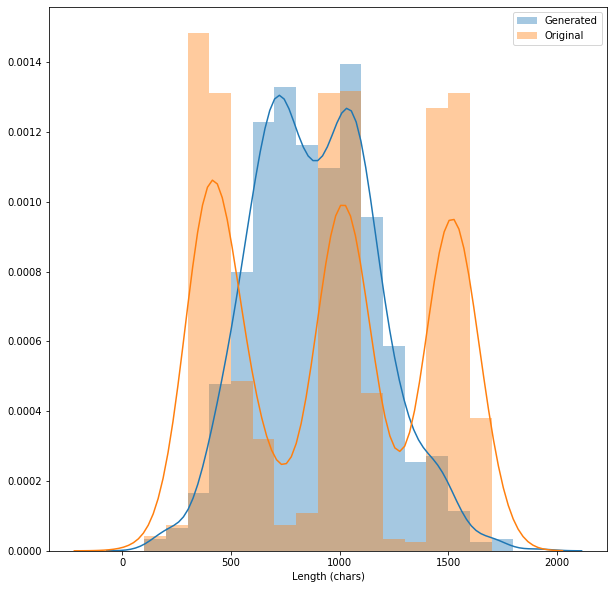

	Correlation score: 0.3609560602234828


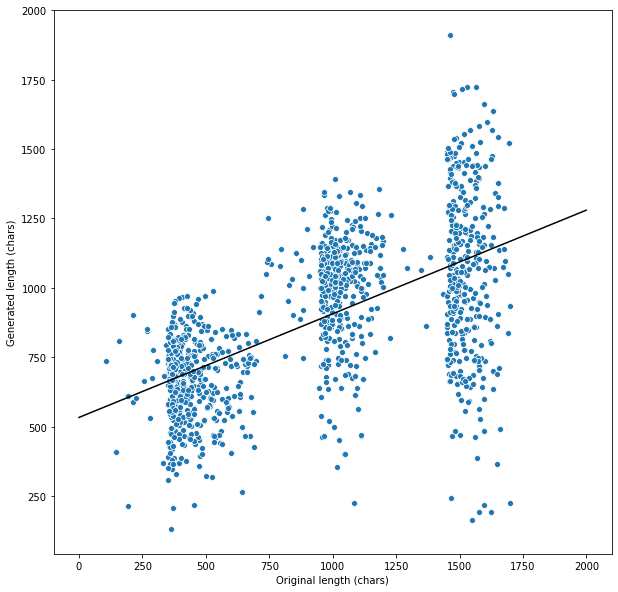

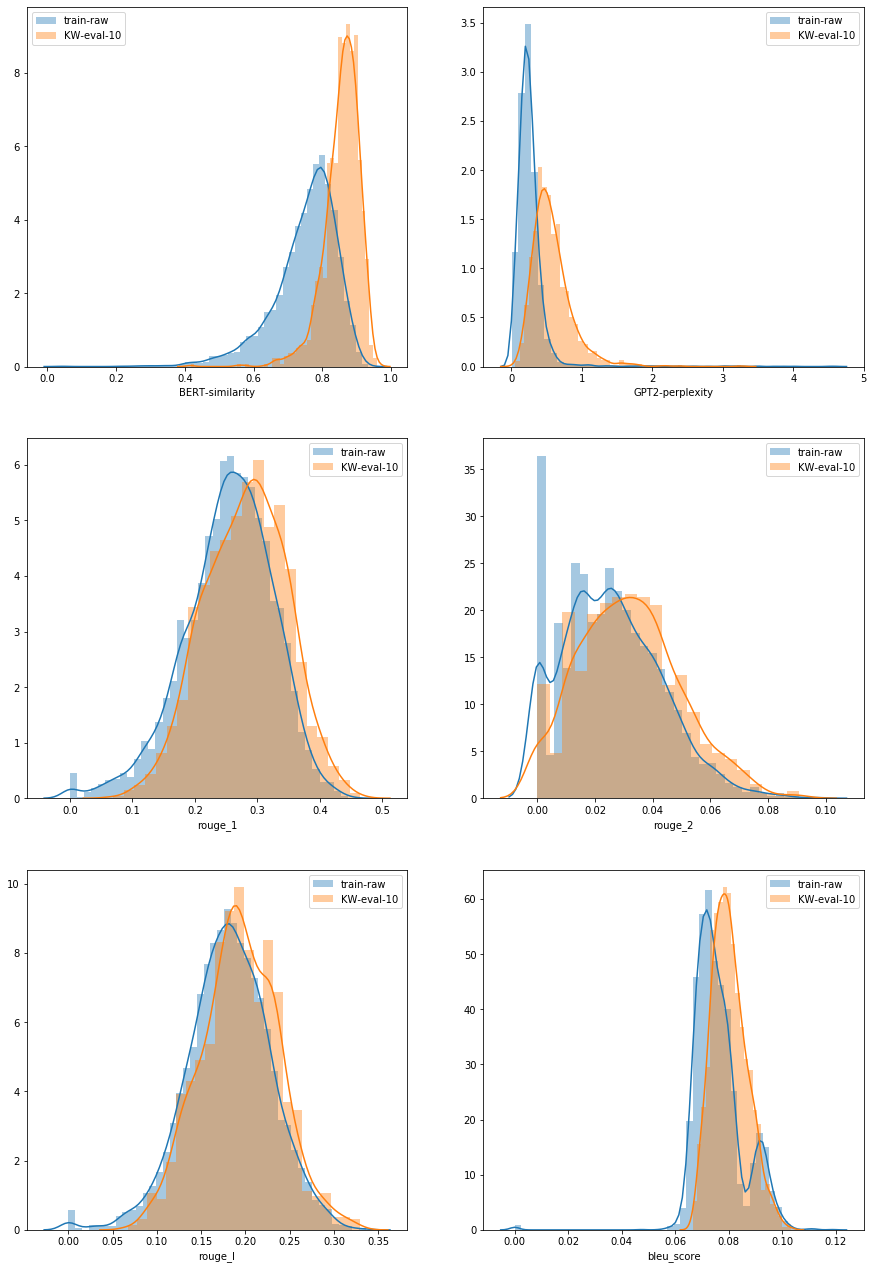

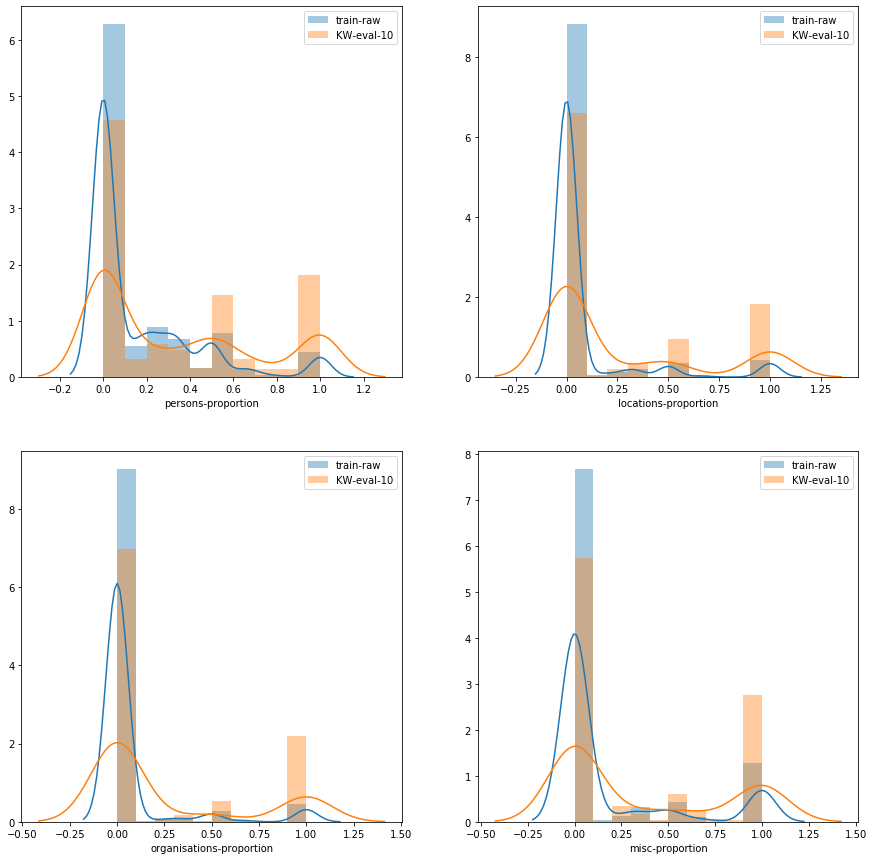

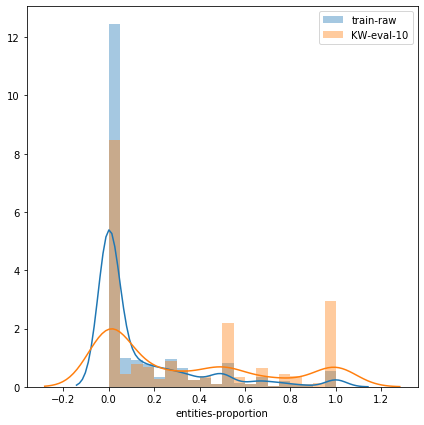

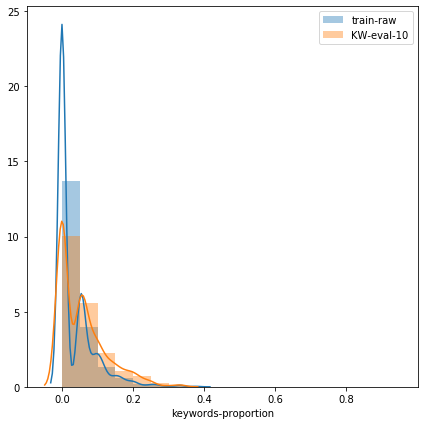

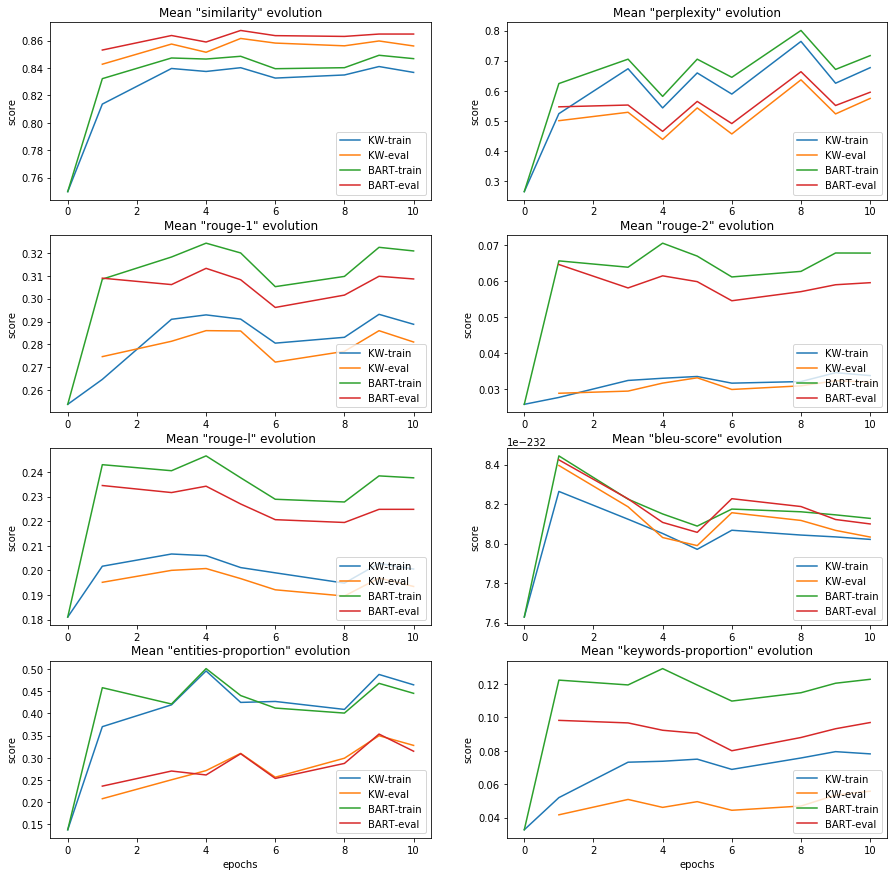

In [20]:
# File to analyse
gen_file = 'data_output/generation_epoch_10_BART_eval.json'
generation_analysis(gen_file)

display_metrics_distributions()
display_detailed_entities_distributions()
display_entities_distributions()
display_keywords_distributions()
display_training_graphs()